In [1]:
import numpy as np
import wavio
from scipy import signal
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

In [2]:
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([
        signal_in[i // N_stretch] if i % N_stretch == 0 else 0
        for i in range(len(signal_in) * N_stretch)
    ])

<IPython.core.display.Javascript object>


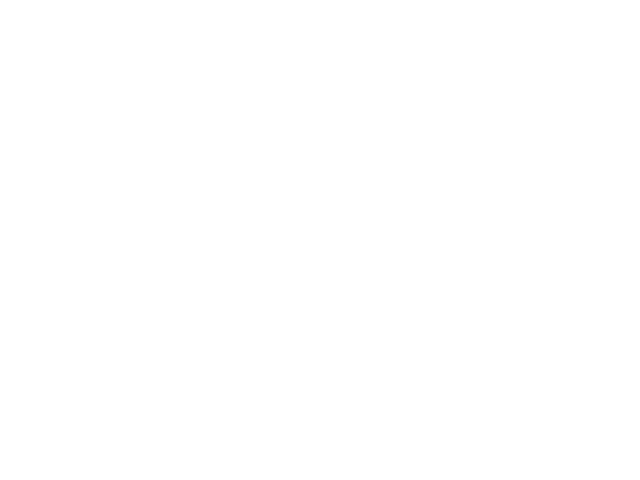

In [3]:
t = np.linspace(-5, 5, 200)
s_t = np.sinc(5 * t)**2

%matplotlib notebook
plt.plot(t, s_t)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


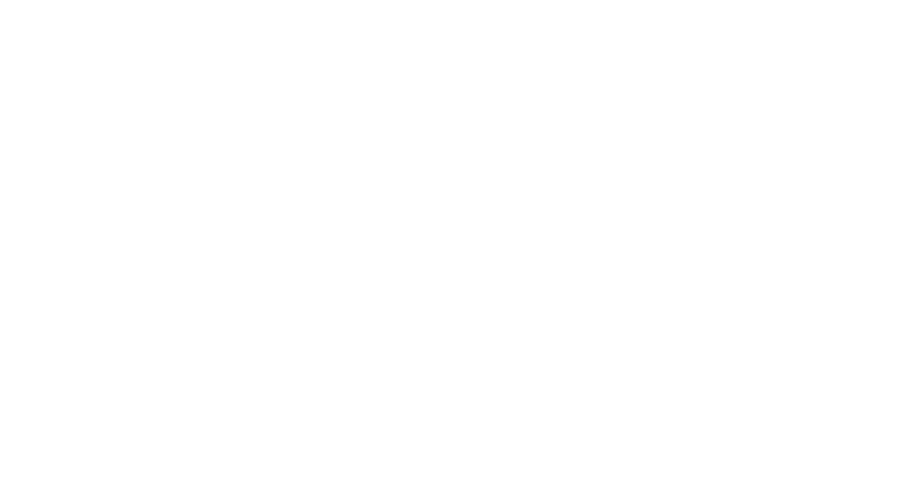

In [4]:
fft_st = np.fft.fft(s_t)
mag = abs(fft_st)
pha = np.angle(fft_st)

%matplotlib notebook
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(np.fft.fftshift(mag))
plt.title('Magnitud')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.unwrap(pha))
plt.title('Fase')
plt.grid()
plt.show()

# Aplicando stretching

<IPython.core.display.Javascript object>


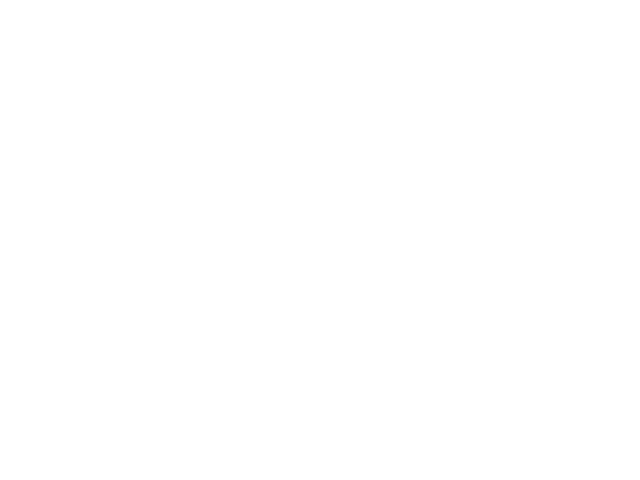

In [5]:
s_t_stretch = stretch_signal(s_t, 3)

%matplotlib notebook
plt.stem(s_t_stretch, use_line_collection=True)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


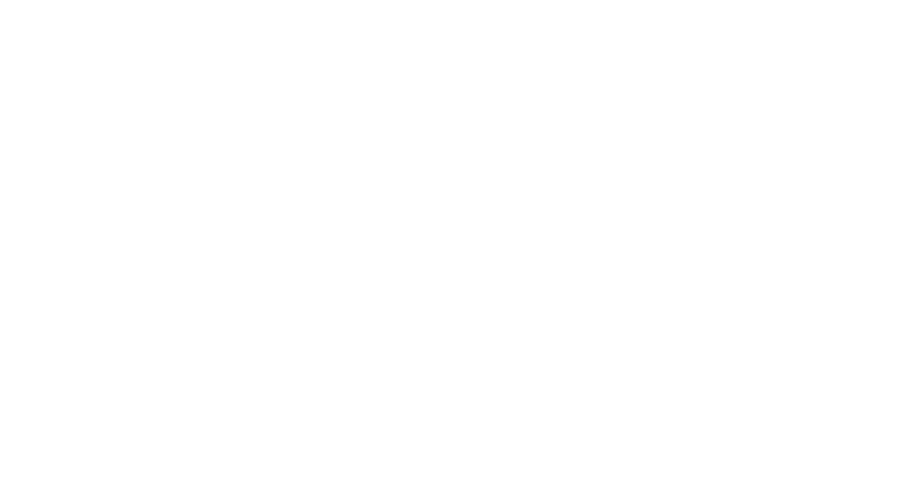

In [6]:
fft_stretched = np.fft.fft(s_t_stretch)
mag_stretched = abs(fft_stretched)
pha_stretched = np.angle(fft_stretched)

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(np.fft.fftshift(mag_stretched))
plt.title('Magnitud')
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.unwrap(pha_stretched))
plt.title('Fase')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


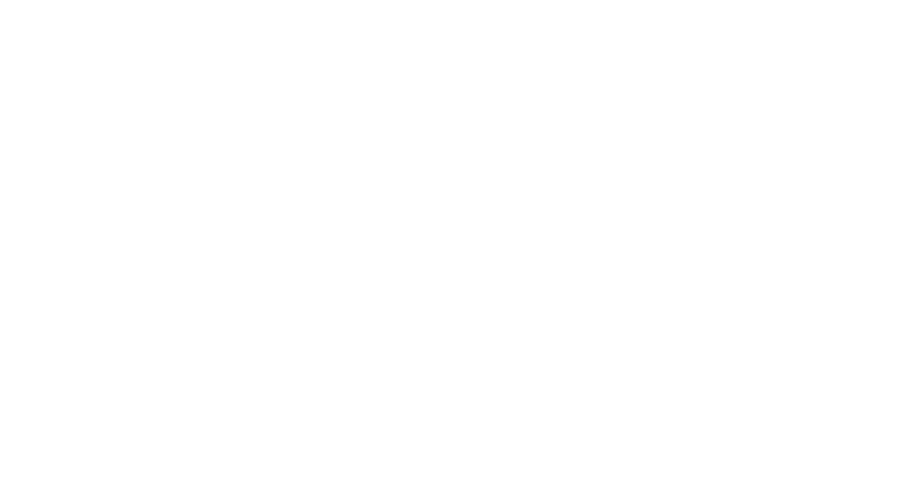

In [7]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(mag_stretched)
plt.title('Magnitud')
plt.grid()

# Función de filtros general

In [57]:
def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / samplerate,
                                    ws=freq_stop / samplerate,
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    elif method == 'cut':
        gd = 0 
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in
    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')
    
    # Para poder filtrar el audio
    if method != 'cut':
        _, gd = signal.group_delay((num, den))
        signal_filtered = signal.lfilter(num, den, signal_to_filt)
        
        # Si se hace padding, se debe cortar de tal forma que se logre sincro-
        # nizar la señal de entrada en función del delay de grupo
        if gd_padding is not None:
            # Delay de grupo aproximado
            delay = round(np.mean(gd))
            
            # Definición de los índices a considerar. Se escogen estos índices
            # ya que se asume que el comportamiento ideal de la señal 3 veces
            # paddeada, se encuentra en el centro del arreglo
            ini_index = int(len(signal_in) + delay)
            end_index = int(2 * len(signal_in) + delay)
            
            # Recortando
            signal_filtered = signal_filtered[ini_index:end_index]
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return gd, signal_filtered / max(abs(signal_filtered))
    else:
        return gd, signal_filtered

# Filtros FIR

## Ventaneo y Kaiser

In [9]:
def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=50, use_exact=True, print_window=True,
                       method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parámetros
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - samplerate: Tasa de muestreo de la señal utilizada
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - use_exact: Booleano que indica si se usa el valor exacto de 
                 transición entre bandas (delta omega)
    - print_window: Booleano que indica si se imprime la ventana
                    seleccionada y su orden
    - method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))  
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # Si es que M es impar, mantenerlo impar, si es que es par, 
    # sumar 1
    M = M  if M % 2 == 0 else M + 1
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hann(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window

In [10]:
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)

Ventana: kaiser
Largo resp. al impulso: 101


<IPython.core.display.Javascript object>


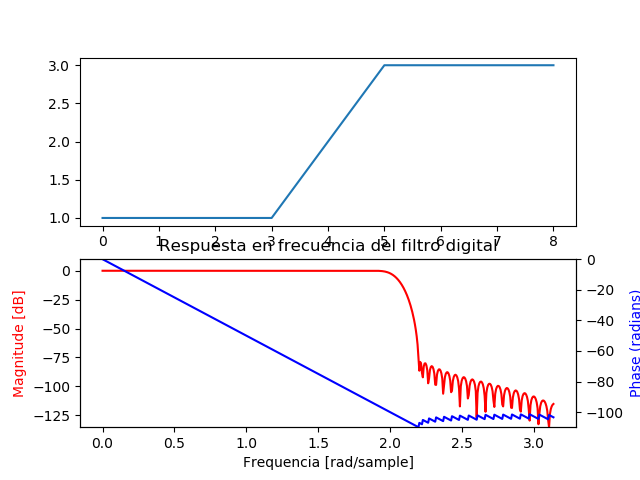

In [43]:
%matplotlib notebook
a,b = lowpass_filter([1,2,3], 1000, 300, 350,
                    method='fir',  gpass=1, gstop=80, 
                    plot_filter=True, normalize=True,
                    gd_padding='constant')

# Testeo de filtros

<IPython.core.display.Javascript object>


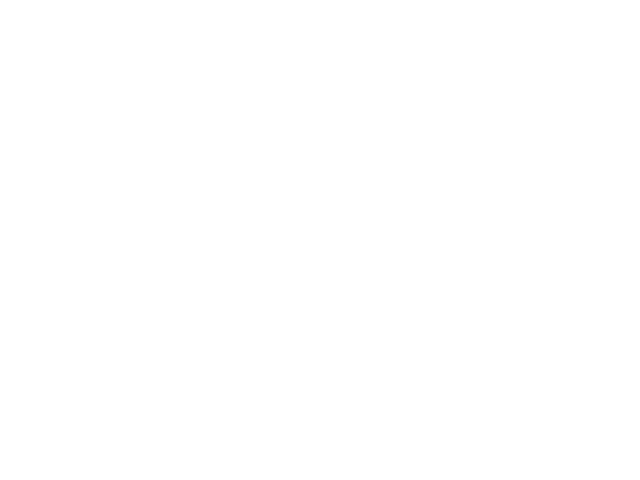

In [12]:
a = fir_filter_adapted(200, 230, 1000, method='remez',
                       gstop=50, use_exact=False, print_window=True,
                       apply_firwin=False)
b = fir_filter_adapted(200, 230, 1000, method='remez',
                       gstop=50, use_exact=False, print_window=True,
                       apply_firwin=True)

%matplotlib notebook
plt.subplot(3,1,1)
plt.stem(a, use_line_collection=True)
plt.subplot(3,1,2)
plt.stem(b, use_line_collection=True)

plt.subplot(3,1,3)
plt.stem(abs(a-b), use_line_collection=True)
plt.show()

<IPython.core.display.Javascript object>


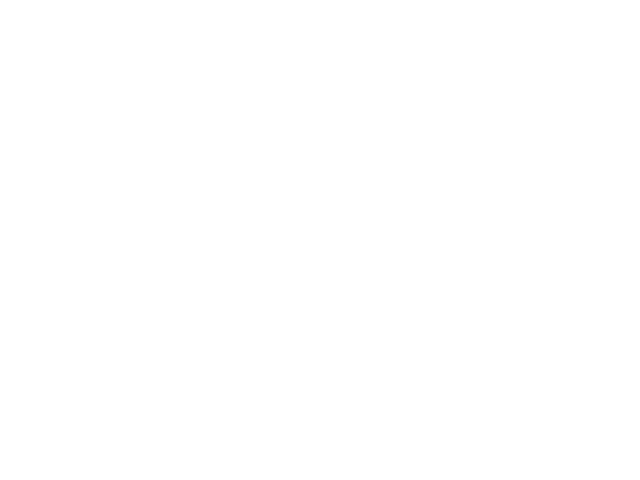

In [13]:
%matplotlib notebook
plt.subplot(1,2,1)
w, ha = signal.freqz(a)
plt.plot(w, 20*np.log10(abs(ha)))
plt.grid()

plt.subplot(1,2,2)
plt.plot(w, np.unwrap(np.angle(ha)))
plt.grid()
plt.show()

# Upsampling and downsampling

In [14]:
def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp

In [15]:
def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir', 
                        fir_method='kaiser', gpass=1, gstop=80, 
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda. Esta es
                 la que se toma en cuenta al momento de hacer el 
                 último corte (por ende, si busca samplear a 2kHz,
                 seleccione este parámetro en 1kHz)
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés 
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    '''
    # Se calcula el paso de la decimación
    N = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = samplerate // N
    
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        gp, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                       freq_stop, method=lp_method, 
                                       fir_method=fir_method, gpass=gpass, 
                                       gstop=gstop, plot_filter=plot_filter, 
                                       normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
        
    elif method == 'resample':
        return new_rate, signal.resample(signal_in, 
                                         len(signal_in)//N)
    
    elif method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_in, 
                                              len(signal_in)//N, 1)
    
    # Aplicando decimación
    return new_rate, decimation_signal(signal_lp, N_decimate=N)

In [16]:
def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir', 
                      fir_method='kaiser', gpass=1, gstop=80, 
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - new_samplerate: Tasa de muestreo deseada de la señal
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés
    - trans_width: Banda de transición entre la frecuencia de corte de
                   la señal original (que representa la frecuencia de 
                   corte del rechaza banda) y la pasa banda del filtro
                   aplicado para eliminar las repeticiones [1]
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N = int(new_samplerate / samplerate)
    
    # Aplicando stretching
    signal_stretched = stretch_signal(signal_in, N_stretch=N)

    # Aplicando zero padding hasta que se obtenga el largo 
    # deseado de la señal
    if N_desired is not None:
        if len(signal_stretched) < N_desired: 
            signal_stretched = np.append(signal_stretched,
                                         [0] * (N_desired \
                                                - len(signal_stretched)))
        else:
            signal_stretched = signal_stretched[:N_desired]
    
    if method == 'lowpass':
        # Definición de las bandas del filtro
        freq_stop = samplerate / 2
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro
        gp, signal_lp = lowpass_filter(signal_stretched, new_samplerate, 
                                       freq_pass, freq_stop, method=lp_method, 
                                       fir_method=fir_method, gpass=gpass, 
                                       gstop=gstop, plot_filter=plot_filter, 
                                       normalize=normalize)
    
    elif method == 'cut':
        # Definición de la frecuencia de corte
        freq_stop = samplerate / 2
        # Método de corte
        signal_lp = lowpass_cut_frequency(signal_stretched, samplerate, 
                                          freq_stop, signal_ref=signal_in)
        
    elif method == 'resample':
        return signal.resample(signal_in, N_desired)
    
    elif method == 'resample_poly':
        # Señal resampleada
        resampled = signal.resample_poly(signal_in, N, 1)
        
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(resampled) < N_desired: 
                resampled = np.append(resampled, 
                                      [0] * (N_desired - len(resampled)))
            else:
                resampled = resampled[:N_desired]
                
        return resampled
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_lp)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_lp / max(abs(signal_lp))
    else:
        return signal_lp

# Testing de función lowpass

In [17]:
filename = '136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

<IPython.core.display.Javascript object>


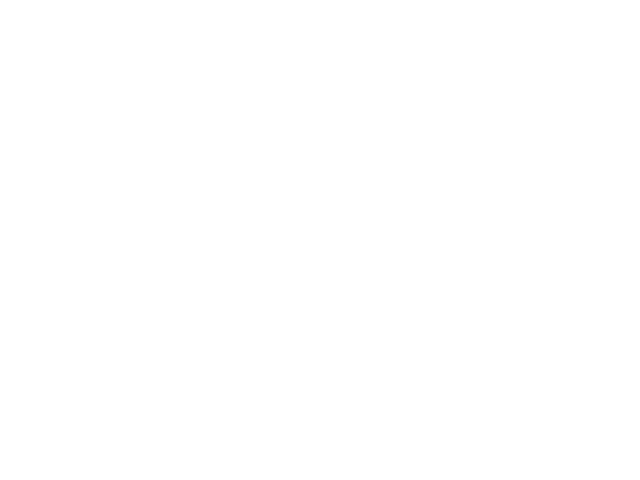

In [18]:
%matplotlib notebook
gd, lowpassed_signal = lowpass_filter(audio, samplerate, 900, 1000, method='fir', 
                                  fir_method='remez', gpass=1, gstop=50, 
                                  plot_filter=True, normalize=True)
Audio(lowpassed_signal, rate=samplerate)

<IPython.core.display.Javascript object>


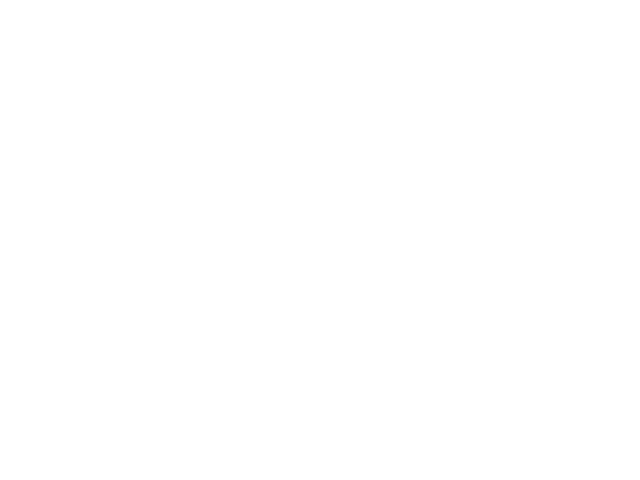

In [19]:
%matplotlib notebook
plt.plot(abs(audio - lowpassed_signal))
plt.show()
Audio(audio - lowpassed_signal, rate=samplerate)

<IPython.core.display.Javascript object>


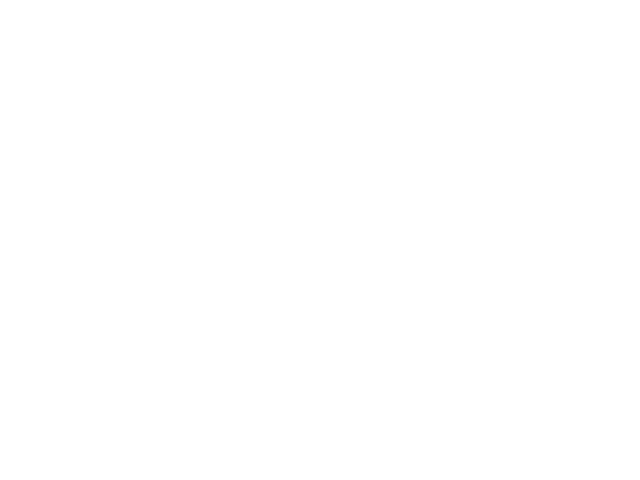

In [20]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.plot(abs(np.fft.fft(audio)))

plt.subplot(1,2,2)
plt.plot(abs(np.fft.fft(lowpassed_signal)))

plt.show()

# Testing de downsampling

In [21]:
new_rate, dwns_signal = downsampling_signal(audio, samplerate, 950, 1000, 
                                  lp_method='fir', fir_method='kaiser',
                                  method='cut', gpass=1, gstop=80, 
                                  plot_filter=False, normalize=True)
# Grabando la señal
wavio.write(f"{filename}_down_{new_rate}.wav", dwns_signal, new_rate, sampwidth=3)
print(new_rate)

2004


# Testing de upsampling

Ventana: kaiser
Largo resp. al impulso: 4395


<IPython.core.display.Javascript object>


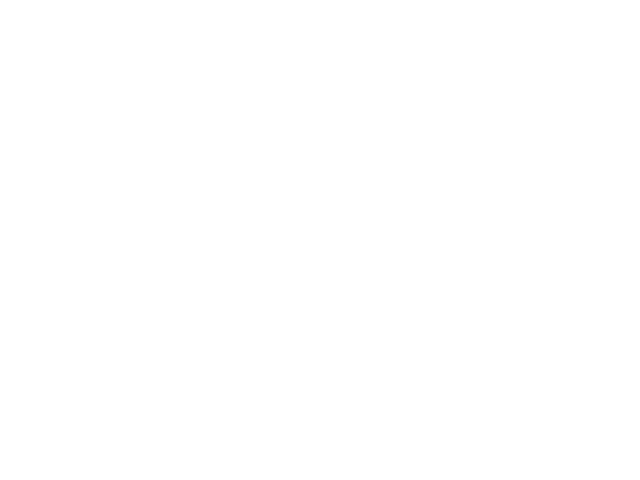

In [22]:
%matplotlib notebook
signal_upped_lp = upsampling_signal(dwns_signal, new_rate, samplerate,
                                   N_desired=len(audio), method='lowpass',
                                   trans_width=50, lp_method='fir', 
                                   fir_method='kaiser', gpass=1, gstop=80, 
                                   plot_filter=True, plot_signals=False,
                                   normalize=True)

signal_upped_cut = upsampling_signal(dwns_signal, new_rate, samplerate,
                                   N_desired=len(audio), method='cut',
                                   trans_width=50, lp_method='fir', 
                                   fir_method='kaiser', gpass=1, gstop=80, 
                                   plot_filter=True, plot_signals=False,
                                   normalize=True)

signal_upped_res = upsampling_signal(dwns_signal, new_rate, samplerate,
                                   N_desired=len(audio), method='resample',
                                   trans_width=50, lp_method='fir', 
                                   fir_method='kaiser', gpass=1, gstop=80, 
                                   plot_filter=True, plot_signals=False,
                                   normalize=True)

signal_upped_pol = upsampling_signal(dwns_signal, new_rate, samplerate,
                                   N_desired=len(audio), method='resample_poly',
                                   trans_width=50, lp_method='fir', 
                                   fir_method='kaiser', gpass=1, gstop=80, 
                                   plot_filter=True, plot_signals=False,
                                   normalize=True)

# Grabando la señal
wavio.write(f"{filename}_upped_{samplerate}.wav", signal_upped_lp, samplerate, sampwidth=3)

<IPython.core.display.Javascript object>


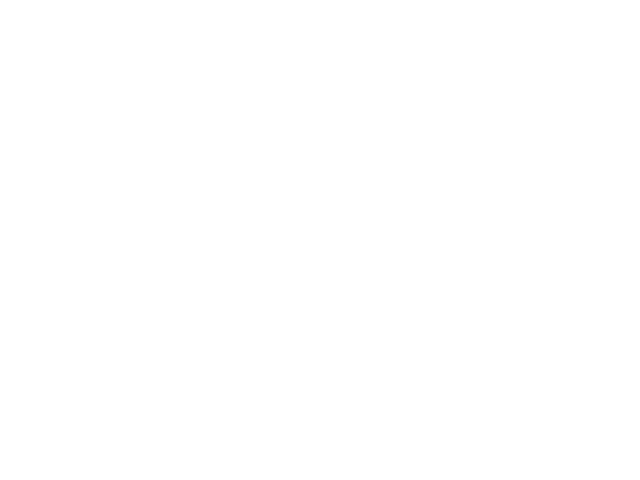

In [23]:
%matplotlib notebook
plt.subplot(2,1,1)
plt.plot(abs(signal_upped_lp - audio))

plt.subplot(2,1,2)
plt.plot(abs(signal_upped_cut - audio))
plt.show()

<IPython.core.display.Javascript object>


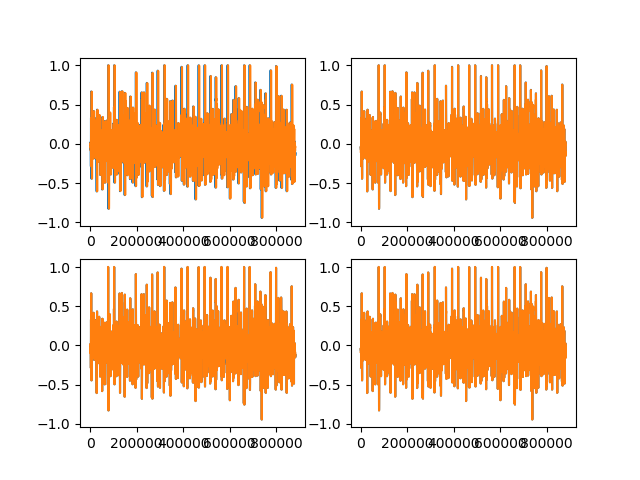

882000
882000
882000
882000
882000


In [24]:
%matplotlib notebook
plt.subplot(2,2,1)
plt.plot(audio)
plt.plot(signal_upped_lp)

plt.subplot(2,2,2)
plt.plot(audio)
plt.plot(signal_upped_cut)

plt.subplot(2,2,3)
plt.plot(audio)
plt.plot(signal_upped_res)

plt.subplot(2,2,4)
plt.plot(audio)
plt.plot(signal_upped_pol)
plt.show()

print(len(audio))
print(len(signal_upped_lp))
print(len(signal_upped_cut))
print(len(signal_upped_res))
print(len(signal_upped_pol))

# Testeo corrección por delay de grupo

<IPython.core.display.Javascript object>


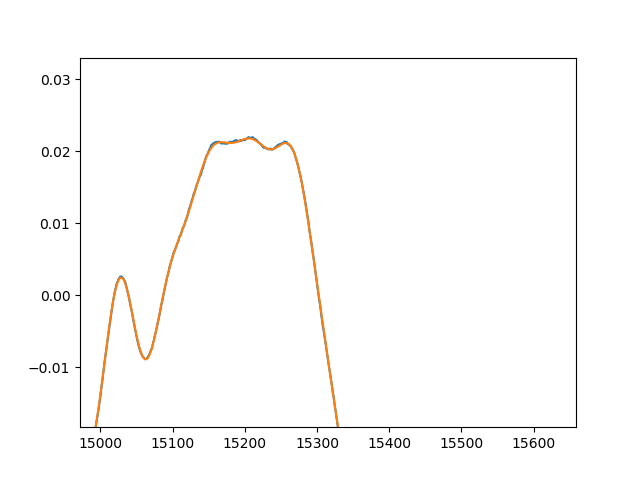

In [58]:
filename = '136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')

gd, lowpassed_signal = lowpass_filter(audio, samplerate, 950, 1000,
                                       method='fir', fir_method='kaiser', gpass=1, 
                                       gstop=80, plot_filter=False, correct_by_gd=True,
                                       gd_padding='periodic', normalize=True)

%matplotlib notebook
plt.plot(audio)
plt.plot(lowpassed_signal)
plt.show()